## Constrained Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to perform Bayesian Optimization on a simple test problem subject to a single constraint.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi], subject to a cos constraining function.

In [1]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt
from xopt.vocs import VOCS

import time
import math
import numpy as np

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

# define variables, function objective and constraining function
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
    constraints={"c": ["LESS_THAN", 0]},
)

In [2]:
# define a test function to optimize


def test_function(input_dict):
    return {"f": np.sin(input_dict["x"]), "c": np.cos(input_dict["x"])}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Expected Improvement acquisition function to perform Bayesian Optimization.

In [3]:
evaluator = Evaluator(function=test_function)
generator = ExpectedImprovementGenerator(vocs=vocs)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate(n_samples) to generate + evaluate initial points
X.random_evaluate(n_samples=2)

# inspect the gathered data
X.data

,x,f,c,xopt_runtime,xopt_error
0,2.41021,0.667899,-0.744252,0.000013,False
1,1.68394,0.993606,-0.112902,0.000003,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

0.35549350001383573
0.398240199952852
0.3932219000416808
0.32266169996000826
0.341278699983377


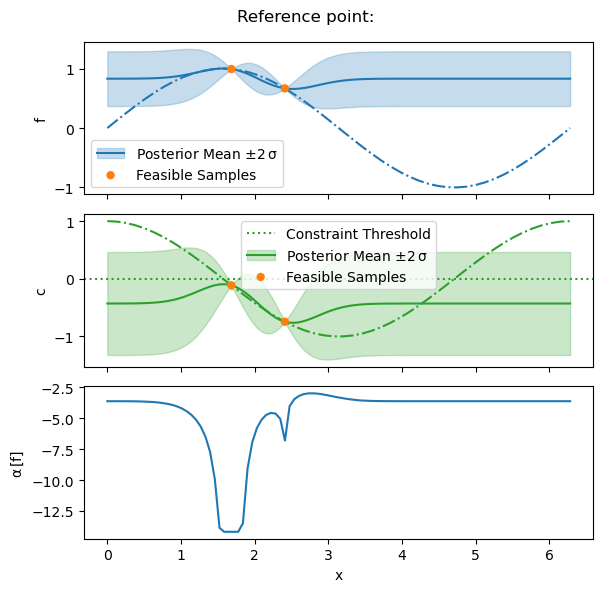

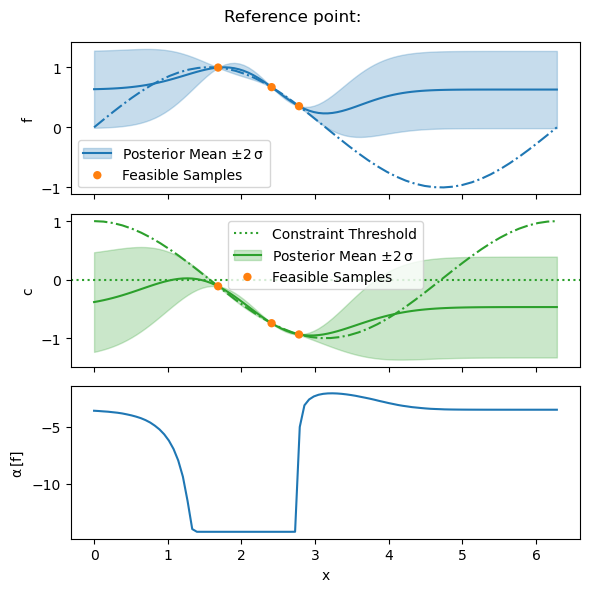

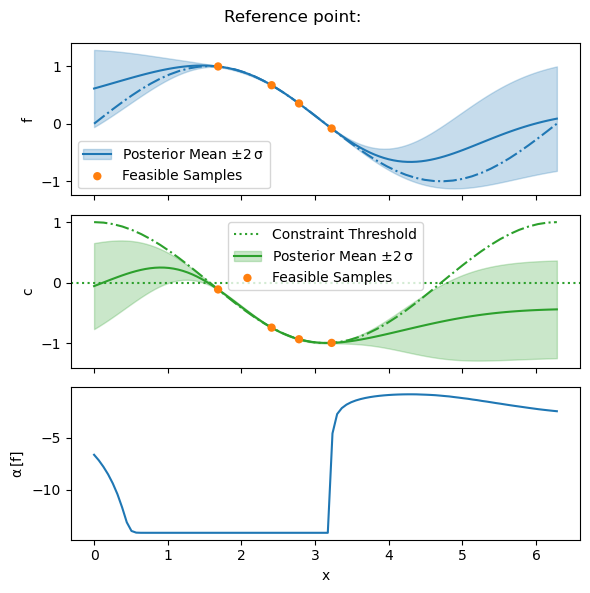

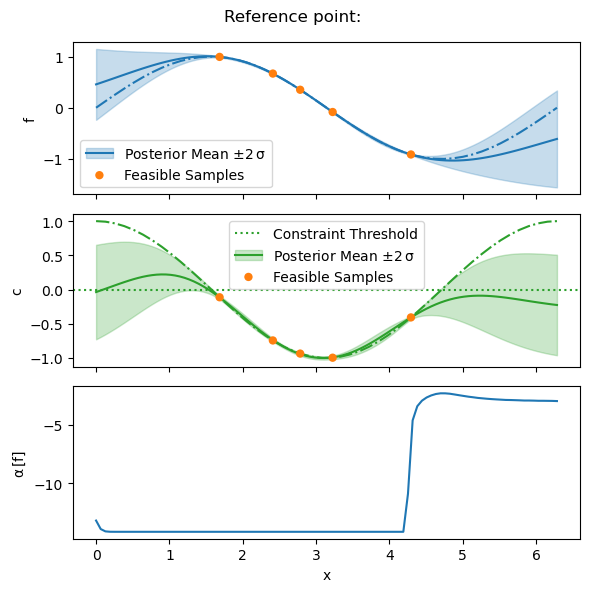

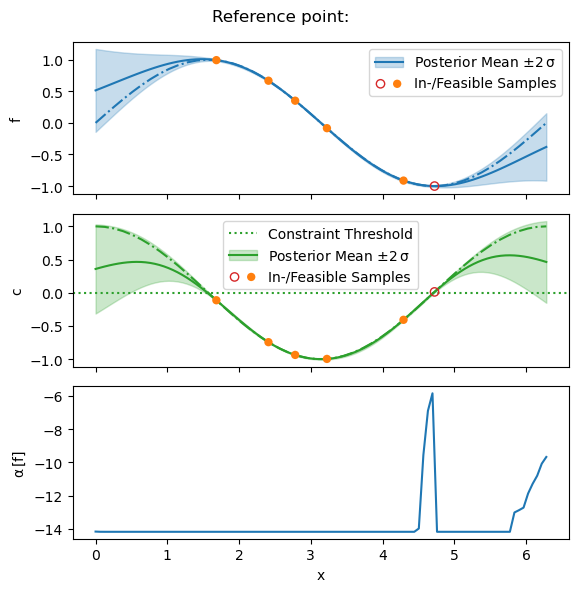

In [8]:
n_steps = 5

# test points for plotting
test_x = np.linspace(*X.vocs.bounds.flatten(), 50)

for i in range(n_steps):
    start = time.perf_counter()
    model = X.generator.train_model()
    fig, ax = X.generator.visualize_model(n_grid=100)
    print(time.perf_counter() - start)

    # add ground truth functions to plots
    out = test_function({"x": test_x})
    ax[0,0].plot(test_x, out["f"], "C0-.")
    ax[1,0].plot(test_x, out["c"], "C2-.")

    # do the optimization step
    X.step()

In [ ]:
# access the collected data
X.data